# Assignment 6: Track 2 Project Report

## Team: dayan-hunt
* Nikhil Kakodkar: 260578689 | nikhil.kakodkar@mail.mcgill.ca
* Karim Koreitem: 260460964 | karim.koreitem@mail.mcgill.ca

## Part 1: Successor Representation in GVF Framework

Bellman's equations written in matrix form we get:

$V_\pi = R_\pi + \gamma P_\pi V_\pi$

this represents a fixed point for the value function for a given policy. With a little matrix manipulation we can find the solution to this fixed ppoint as:

$V_\pi = (I - \gamma P_\pi)^{-1} R_\pi$

This can then be represented as:

$V_\pi = \Phi_\pi R_\pi\ \ $ where $\ \ \Phi_\pi = (I - \gamma P_\pi)^{-1}$

The main concept of Successor Representation[1] is to have an encoding for the state of the environment such that it represents the future transitions under the given policy. In the above equation $\Phi_\pi$ can be thought of representing such an encoding. We now think of i'th row of $\Phi_\pi$ as represnting an encoding for the corresponding state, where the j'th element of the row represents the future occupancy of the j'th state.

Now with such a representation we can directly learn the temporal transition behaviour of a policy encoded in $\Phi_\pi$. Hence we can now directly calculate the value function by simple taking an inner product of $\Phi_\pi$ and the reward $R_\pi$.

This type of reformulation of the problem fits very naturally into the framework of the idea of General Value Function (GVF). In GVF framework the idea of the reward function is abstracted away. This can now be replaced by any property of the environment that might be of interest to us. Or also any combination of multiple properties of the environment. This is termed as the 'Cummulant'. 

$V_{\pi, \gamma, C} (s) = E[\sum_{k=t}^{\infty} C_{k+1} \Pi_{i=t+1}^{k} \gamma(S_i) | S_{t} = s, A_{t:\infty} \sim \pi]$

or in matric notation:

$V_{\pi, \gamma, C} = C_\pi + \gamma P_\pi V_{\pi, \gamma, C}$

where $C$ represents the cummulant and  $\gamma(s)$ represents the discounting or in general a termination condition. Incorporating the idea of successor representations, we get:

$V_{\pi, \gamma, C} = \Phi_{\pi, \gamma} C_\pi\ \ $ where 
$\ \ \Phi_{\pi, \gamma} = (I - \gamma P_\pi)^{-1}$

This means we can now learn a-priory the temporal behaviour of a policy in an environment and then calculate the GVF later by the desired cummulant function.

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from math import sqrt
import matplotlib.pyplot as plt
from sr_main import run_experiment, compute_transition_mtx, compute_reward_vector

In [2]:
def init_default_config_tenbyten():
    config = {'switch_reward': False,
              'terminal_step' : 80000,
              'switch_reward_at_step' : 40000,
              'episode_length' : 50,
              'maze_type' : 'tenbyten',
              'maze_params' : {
                  'row' : 10,
                  'col' : 10,
                  'start_row' : 1,
                  'start_col' : 1
              },
              'learning_alg_params' : {
                  'alpha' : 0.5,
                  'gamma' : 0.9,
              },              
             }
    return config

## Track 2: Question 1: Learning SR using TD(0)

For this report we use a simple 10\*10 gridworld with the starting position at (0,0) and goal position at (9,9). The action space consists of 4 actions in each of the four directions. All the transitions are considered deterministic. And the goal state (9,9) is an absorbing state.

In [3]:
config = init_default_config_tenbyten()
result = run_experiment(config)

In [4]:
terminal_step = config['terminal_step']
approx_Phi_pi = result[terminal_step-1]['Phi_pi']

In [5]:
# Calculate exact phi_pi for 10x10 gridworld
state_len = config['maze_params']['row']*config['maze_params']['col']
gamma = config['learning_alg_params']['gamma']
P_pi = compute_transition_mtx(config)
exact_Phi_pi = inv(np.identity(state_len)-gamma*P_pi)

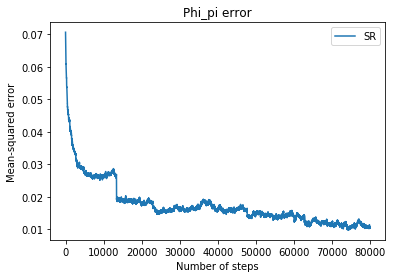

In [6]:
## Phi_pi error
err_sr = []

for s in range(terminal_step):
    est_Phi_pi = result[s]['Phi_pi']
    err_sr.append(np.mean(np.square(est_Phi_pi - exact_Phi_pi)))
    
# Plotting Phi_pi error:
plt.ylabel('Mean-squared error')
plt.xlabel('Number of steps')
plt.title('Phi_pi error')
plt.plot(err_sr, label='SR')
plt.legend()

The graph here presents the mean-squared error between the exact $\Phi_\pi$, calculated as: 

$\Phi_\pi = (I - \gamma P_\pi)^{-1}$

and the $\Phi_\pi$ calculated by a one-step update rule given by:

$\Phi_\pi(s,j) \leftarrow \Phi_\pi(s,j) + \alpha [\mathbb{1}_{s=j} + \gamma \Phi_\pi(\acute{s},j) - \Phi_\pi(s,j)]$

where $s$ is the current state, $\acute{s}$ is the next state.

## Track 2: Question 2: Value Prediction with SR


In [7]:
r1_pi, r2_pi = compute_reward_vector(config)

In [8]:
exact_V_pi_R1 = exact_Phi_pi.dot(r1_pi)
approx_V_pi = approx_Phi_pi.dot(r1_pi)
td_V_pi = result[terminal_step-1]['V_pi']

In [9]:
V_pi_sr = np.zeros((state_len,1))
V_pi_td = np.zeros((state_len,1))

err_sr = []
err_regular_td = []

for s in range(terminal_step):
    V_pi_sr = result[s]['Phi_pi'].dot(r1_pi)
    err_sr.append(np.mean(np.square(V_pi_sr - exact_V_pi_R1)))

    V_pi_td = result[s]['V_pi']
    err_regular_td.append(np.mean(np.square(V_pi_td - exact_V_pi_R1)))

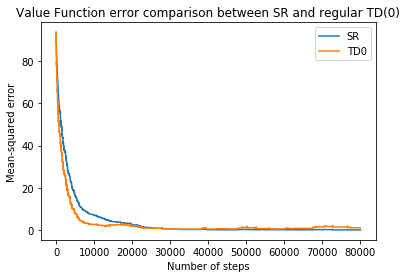

In [10]:
# Plotting value function error for the two algorithms:
plt.ylabel('Mean-squared error')
plt.xlabel('Number of steps')
plt.title('Value Function error comparison between SR and regular TD(0)')
plt.plot(err_sr, label='SR')
plt.plot(err_regular_td, label='TD0')
plt.legend()

This graph shows that mean-squared error for value-function calculated by two different methods:
1. Using the successor representation as described in the previous section, repeated here:
First we calculate the $\Phi_\pi$ using the one-step update rule:

  $\Phi_\pi(s,j) \leftarrow \Phi_\pi(s,j) + \alpha [\mathbb{1}_{s=j} + \gamma \Phi_\pi(\acute{s},j) - \Phi_\pi(s,j)]$

  following which we can calculate the value function as:

  $V_\pi = \Phi_\pi R_\pi\$

2. By vanilla TD(0) method:

  $V_\pi(s) \leftarrow V_\pi(s) + \alpha [R_t + \gamma V_\pi(\acute{s}) - V_\pi(s)]$

The baseline used for the error computation is the calculated directly from the matrix computation given by:

$V_\pi = \Phi_\pi R_\pi\ \ $ where $\ \ \Phi_\pi = (I - \gamma P_\pi)^{-1}$

## Question 3: Tracking with SR

In [11]:
config = init_default_config_tenbyten()
config['switch_reward'] = True
result = run_experiment(config)

state_len = config['maze_params']['row']*config['maze_params']['col']
terminal_step = config['terminal_step']
switch_step = config['switch_reward_at_step']

In [12]:
# Calculate exact phi_pi for 10x10 gridworld
gamma = config['learning_alg_params']['gamma']
P_pi = compute_transition_mtx(config)
exact_Phi_pi = inv(np.identity(state_len)-gamma*P_pi)

In [13]:
r1_pi, r2_pi = compute_reward_vector(config)

In [14]:
exact_V_R1 = exact_Phi_pi.dot(r1_pi) 
exact_V_R2 = exact_Phi_pi.dot(r2_pi)

err_sr = []
err_regular_td = []

for s in range(terminal_step):
    if s <= switch_step:
        pass
        V_pi_sr = result[s]['Phi_pi'].dot(r1_pi)
        err_sr.append(np.mean(np.square(V_pi_sr - exact_V_R1)))
        
        V_pi_td = result[s]['V_pi']
        err_regular_td.append(np.mean(np.square(V_pi_td - exact_V_R1)))
    else:
        V_pi_sr = result[s]['Phi_pi'].dot(r2_pi)
        err_sr.append(np.mean(np.square(V_pi_sr - exact_V_R2)))
    
        V_pi_td = result[s]['V_pi']
        err_regular_td.append(np.mean(np.square(V_pi_td - exact_V_R2)))

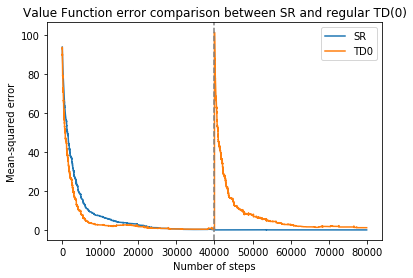

In [15]:
# Plotting value function error for the two algorithms:
plt.ylabel('Mean-squared error')
plt.xlabel('Number of steps')
plt.title('Value Function error comparison between SR and regular TD(0)')
plt.plot(err_sr, label='SR')
plt.plot(err_regular_td, label='TD0')
plt.axvline(x=switch_step, color='grey', linestyle='--')
plt.legend()

This plot represents the errors same as in previous section. But in this case we change the reward function at 39000th step. From 0 to 40000th step the reward function is given by:

$R(\acute{s}) = 0 \ \ $ if $\ \ \acute{s} == (9,9) \ \ $  $-1$ otherwise

And from 40000th step till the end the reward is given by:

$R(\acute{s}) = 1 \ \ $ if $\ \ \acute{s} == (9,9) \ \ $  $0$ otherwise.

As we can see, since the successor representation method learns temporal behaviour of the policy, it's estimate of the value function is still very accurate after the change in the reward function. But TD(0) develops a big error in it's estimate of the value function during the switch in reward, but given some time, its is able to adapt to the change.

## Question 4: Eigendecomposition

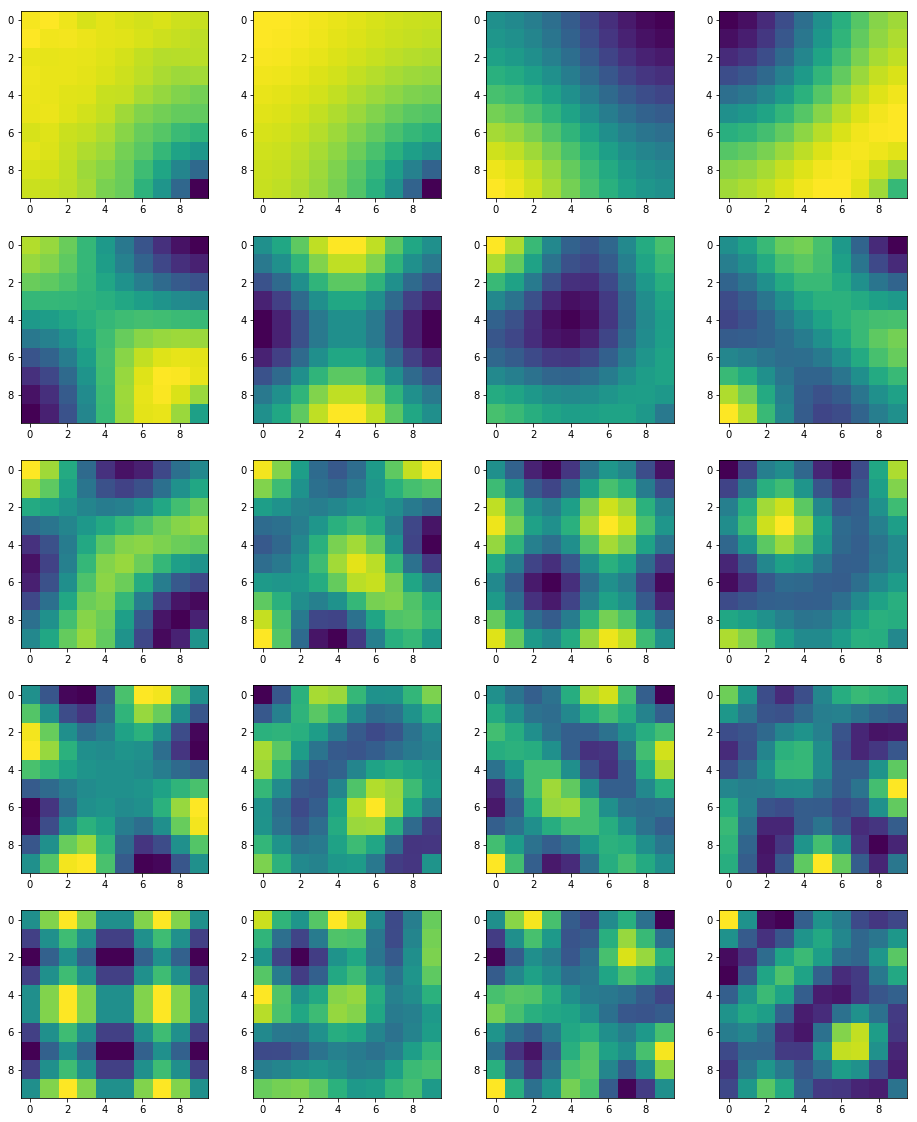

In [16]:
nrow, ncol = config['maze_params']['row'], config['maze_params']['col']
eig_vals, eig_vecs = np.linalg.eig(exact_Phi_pi)

vec_ids = np.flip(np.argsort(eig_vals), 0)[:20]

fig = plt.figure(figsize=(16, 20))

for n, i in enumerate(vec_ids):
    new_vec = eig_vecs[:,i].reshape([nrow,ncol])
    
    ax1 = fig.add_subplot(5, 4, n+1)   
    ax1.imshow(new_vec)